In [2]:
from imports_func import *
from dbase import *

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_full.npy') 
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full.npy')
jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full.npy')
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs

#X = X1 + X2
print(np.shape(X))

#mask=np.all(np.equal(X,0), axis=0)
#X = X[:,~mask]
#print(np.shape(X))
#np.save('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_full',mask)
#np.save('/home/miquel/ForMiquel/CLEAN2/X_full', X)

(124, 573922)


In [4]:
# build vector with dt's
dt=[]
for i in range(0,len(sub_id)):
    dt.append(Subjects[sub_id[i]].jacobians[jac_idx[i]].dt)
dt = np.asarray(dt)/365

In [5]:
# build vector with ages
ages=[]
for i in range(0,len(sub_id)):
    ages.append(Subjects[sub_id[i]].age_bl)
    
ages = np.asarray(ages) 

In [6]:
def cross_validation_analysis(X, y, zeros, clf, splits, percentage, dt, ages, age_dt):
      
    split=0
    box = np.zeros((121,145,121))
    precision_l=[]
    recall_l=[]
    threshold_l=[]
    print("split:",split)
    
    ages=np.reshape(ages, (124,1))
    dt=np.reshape(dt, (124,1))
    
    ages_norm = (ages - np.mean(ages))/np.std(ages)
    dt_norm = (dt - np.mean(dt))/np.std(dt)
        
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.25, random_state=40)
    for train_index, test_index in spl.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_train = dt[train_index]
        dt_test = dt[test_index]
        dt_norm_train = dt_norm[train_index]
        dt_norm_test = dt_norm[test_index]
        ages_norm_train=ages_norm[train_index]
        ages_norm_test=ages_norm[test_index]
        

        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
    
        ## aquí falta poner voxeles usados en matriz 3D de participaciones
    
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]
        
        
        
        if age_dt == 1:
            X_train_s=np.concatenate((X_train_s, ages_norm_train), axis=1)
            X_train_s=np.concatenate((X_train_s, dt_norm_train), axis=1)
            X_test_s=np.concatenate((X_test_s, ages_norm_test), axis=1)
            X_test_s=np.concatenate((X_test_s, dt_norm_test), axis=1)
        
        
        
        if split == 0:
            print("shape X_train:",np.shape(X_train_s))
        
        model = clf
        y_score_train = model.fit(X_train_s, y_train).decision_function(X_train_s)
        model = clf
        y_score = model.fit(X_train_s, y_train).decision_function(X_test_s)
        
      
        mask0 = np.where(dt_train>400)
        mask0 = np.asarray(mask0)
        y_train = y_train[mask0][0]
        y_score_train = y_score_train[mask0][0]
    
        mask0 = np.where(dt_test>400)
        mask0 = np.asarray(mask0)
        y_test = y_test[mask0][0]
        y_score = y_score[mask0][0]
        
        average_precision_train = average_precision_score(y_train, y_score_train)
        average_precision = average_precision_score(y_test, y_score)
        
        precision_t, recall_t, thresholds_t = precision_recall_curve(y_train, y_score_train) 
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)    
        
        f1 = 2 * (precision * recall) / (precision + recall)
    
        maxi = np.amax(f1)
        maxi_idx = np.argmax(f1)
        
        if precision[maxi_idx] != 0 or recall[maxi_idx] != 0:
            precision_l.append(precision[maxi_idx])
            recall_l.append(recall[maxi_idx])
            threshold_l.append(thresholds[maxi_idx])
            print("split:",split)
            split = split + 1
            plt.plot(recall_t, precision_t, label='area = %0.2f' % average_precision, color="blue")
            plt.plot(recall, precision, label='area = %0.2f' % average_precision, color="green")
            #axarr[split,0].step(recall, precision, color='b', alpha=0.2, where='post')
            #axarr[split,0].fill_between(recall, precision, step='post', alpha=0.2, color='b')

            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
            plt.show()
            
        
        aux = np.zeros((121*145*121))
        aux[~zeros] = np.asarray(S.get_support())
        aux = np.reshape(aux, (121,145,121))
        box = box + aux
        
    #np.save('/home/miquel/ForMiquel/CLEAN2/pvalues_appareances_20_splits_full', box)
    #new_img = nib.Nifti1Image(box, np.eye(4))
    #nib.save(new_img, "img_pvalues_appareances_20_splits_full.nii.gz")
    
    print("thresholds:", threshold_l)
    print()
    print("precisions:", precision_l)
    print()
    print("precision mean:", np.mean(precision_l))
    print()
    print("recalls:", recall_l)
    print()
    print("recall mean:", np.mean(recall_l))        

    
    
    
    

split:

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   177    185    190 ..., 573919 573920 573921] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


 0
shape X_train: (93, 574)
split: 0


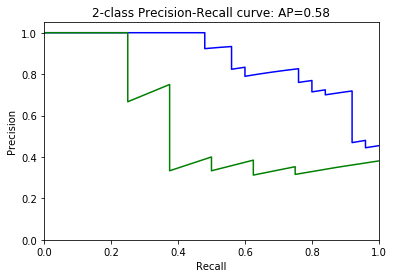

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    173    174 ..., 573917 573920 573921] are constant.
  UserWarning)


split: 1


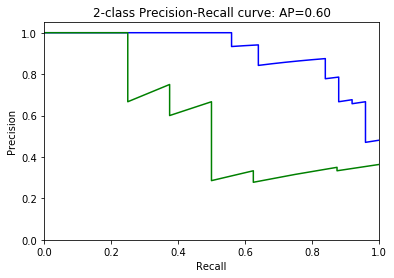

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 573917 573920 573921] are constant.
  UserWarning)


split: 2


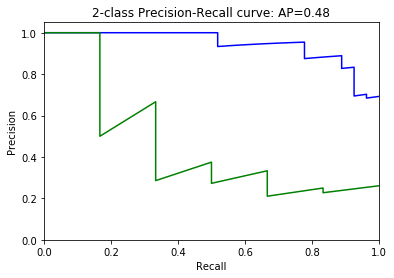

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   205    289    290 ..., 573917 573920 573921] are constant.
  UserWarning)


split: 3


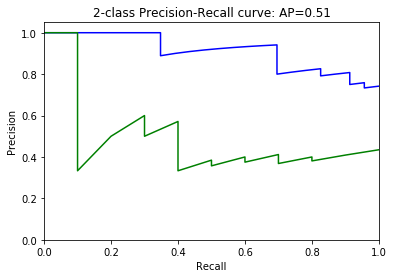

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    178    179 ..., 573904 573905 573906] are constant.
  UserWarning)


split: 4


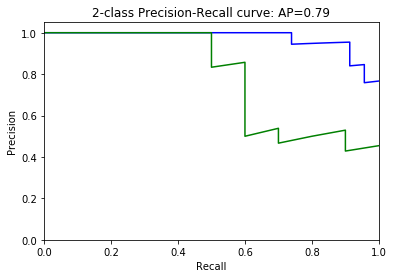

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    175    176 ..., 573915 573916 573919] are constant.
  UserWarning)


split: 5


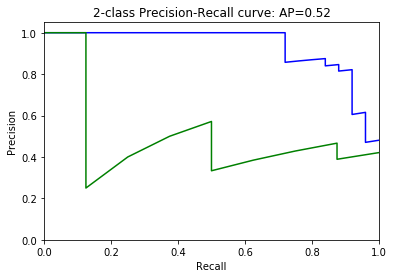

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   175    176    177 ..., 573915 573916 573919] are constant.
  UserWarning)


split: 6


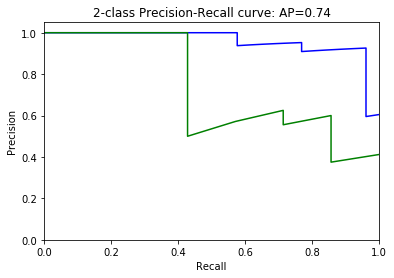

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 573904 573905 573906] are constant.
  UserWarning)


split: 7


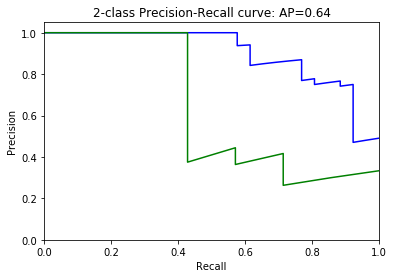

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 573896 573897 573898] are constant.
  UserWarning)


split: 8


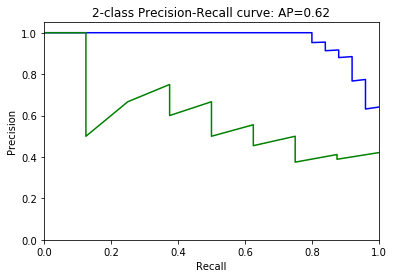

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    205    265 ..., 573816 573831 573869] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   196    205    265 ..., 573839 573847 573862] are constant.
  UserWarning)


split: 9


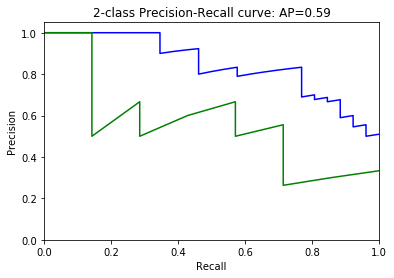

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   178    179    183 ..., 573912 573913 573914] are constant.
  UserWarning)


split: 10


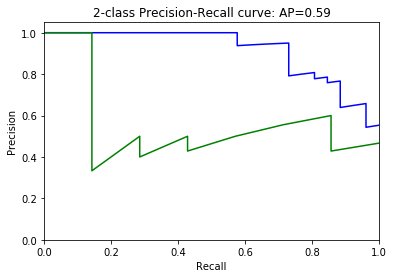

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   149    177    185 ..., 573915 573916 573919] are constant.
  UserWarning)


split: 11


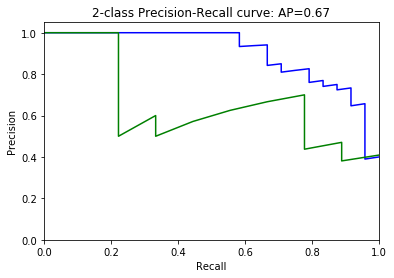

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   196    289    290 ..., 573912 573913 573914] are constant.
  UserWarning)


split: 12


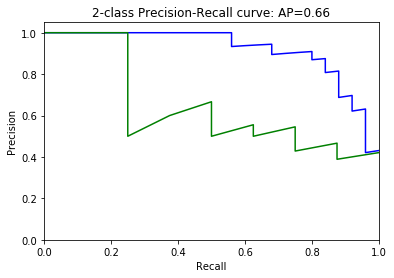

split: 13


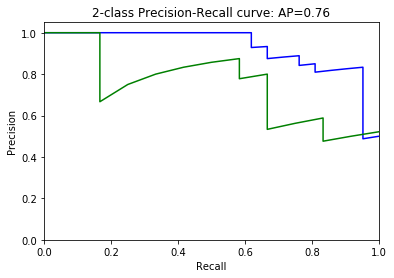

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     85     99 ..., 573915 573916 573919] are constant.
  UserWarning)


split: 14


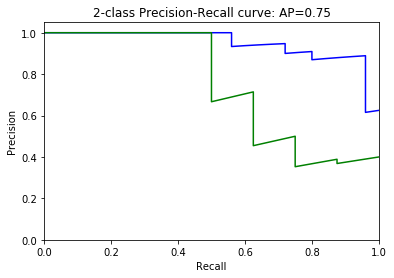

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 573839 573847 573862] are constant.
  UserWarning)


split: 15


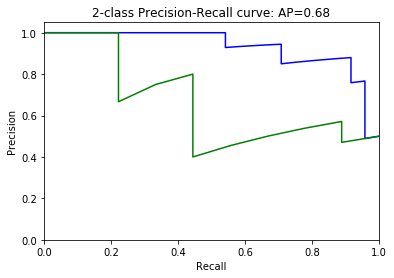

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    197 ..., 573912 573913 573914] are constant.
  UserWarning)


split: 16


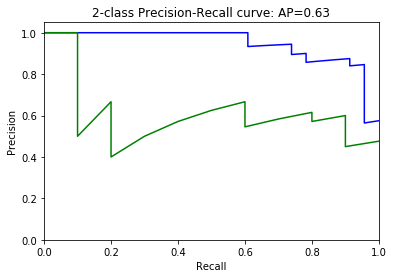

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    85    173    174 ..., 573862 573892 573893] are constant.
  UserWarning)


split: 17


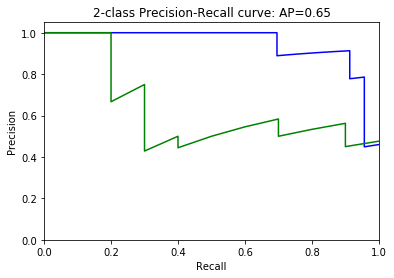

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 573912 573913 573914] are constant.
  UserWarning)


split: 18


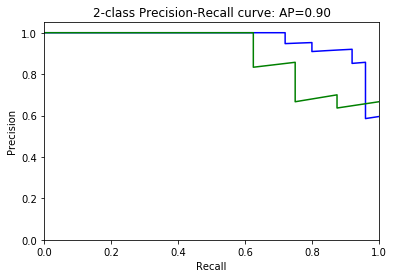

thresholds: [-0.99355575338044799, 0.099881419575879121, -0.17933857455875263, -0.71753598969145194, 0.14054466463368678, -0.019721981666124877, -0.11522844148959233, 0.3715955409137186, -0.096683572832517328, 0.17101354723344192, -0.0011474031480613878, 0.2303958702100424, -0.09242776189174623, -0.071491815568775013, 0.16713041501798953, -0.063110200221156931, -0.20766527079896502, -0.20571025184654479, -0.079058206726703439]

precisions: [0.38095238095238093, 0.66666666666666663, 0.33333333333333331, 0.43478260869565216, 0.8571428571428571, 0.46666666666666667, 0.59999999999999998, 1.0, 0.5, 0.55555555555555558, 0.59999999999999998, 0.69999999999999996, 0.54545454545454541, 0.80000000000000004, 0.7142857142857143, 0.5714285714285714, 0.59999999999999998, 0.5625, 0.66666666666666663]

precision mean: 0.608180819308

recalls: [1.0, 0.5, 0.66666666666666663, 1.0, 0.59999999999999998, 0.875, 0.8571428571428571, 0.42857142857142855, 0.75, 0.7142857142857143, 0.8571428571428571, 0.77777777

In [9]:
zeros = np.load('/home/miquel/ForMiquel/CLEAN2/zero_cols_JB_full.npy') 
#X=np.transpose(np.transpose(X)/dt)
clf = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced')
splits=20
percentage=0.1
age_dt=0 #1 if we want to add normalized age and dt as features
cross_validation_analysis(X, y, zeros, clf, splits, percentage, dt, ages, age_dt)